# Part III: Build Transformer with PyTorch [25 points]
Implement a Transformer model from scratch using the PyTorch framework. Train the model on a provided dataset, exploring various optimization techniques and hyperparameter tuning to achieve optimal performance.
Every component of the Transformer as defined in the paper is expected to be implemented.
The final model should achieve a test accuracy of greater than 80%.

## Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import time
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchinfo import summary
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

train_path = '/kaggle/input/yelp-polarity-dataset/train.csv'
test_path = '/kaggle/input/yelp-polarity-dataset/test.csv'


2. Data exploration:
   - Read, preprocess, and print the main statistics about the dataset.
   - Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).
    
3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [8]:
train_df = pd.read_csv(train_path, header=None, names=['rating', 'review'])
test_df = pd.read_csv(test_path, header=None, names=['rating', 'review'])

print("Number of training samples:", train_df.shape[0])
print("Number of testing samples:", test_df.shape[0])
print("\nTraining label distribution:")
print(train_df['rating'].value_counts())

def pprocess(text):
    text = text.lower()
    text = re.sub(r'[' + re.escape(string.punctuation) + ']', '', text)
    text = text.strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

train_df['tokens'] = train_df['review'].apply(pprocess)
test_df['tokens'] = test_df['review'].apply(pprocess)

train_df['word_count'] = train_df['tokens'].apply(len)

avg_word_count = train_df['word_count'].mean()
print("\nAverage word count per review in training data:", avg_word_count)



Number of training samples: 560000
Number of testing samples: 38000

Training label distribution:
rating
1    280000
2    280000
Name: count, dtype: int64

Average word count per review in training data: 68.61306071428571


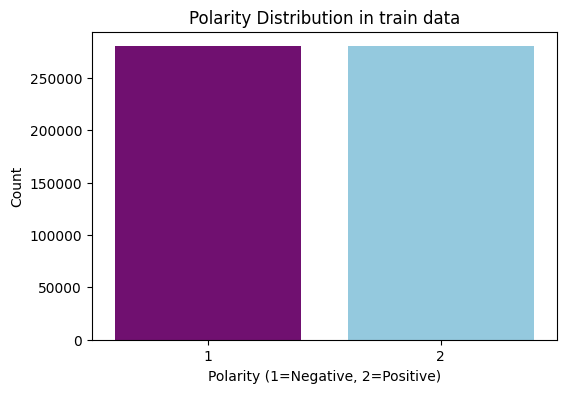

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=train_df, palette=['purple','skyblue'])
plt.title("Polarity Distribution in train data")
plt.xlabel("Polarity (1=Negative, 2=Positive)")
plt.ylabel("Count")
plt.show()



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


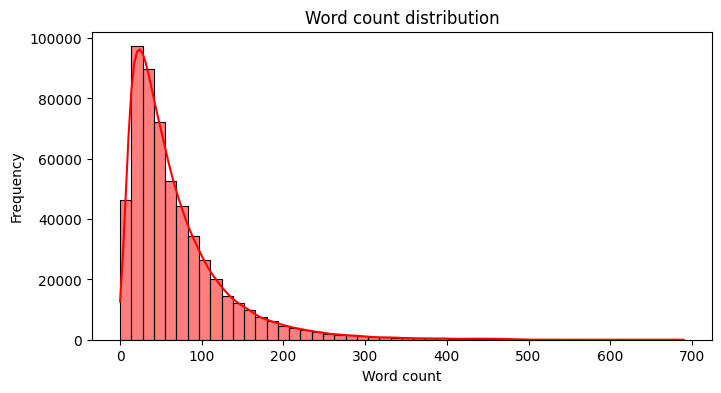

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(train_df['word_count'], bins=50, kde=True,color='red')
plt.title("Word count distribution")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


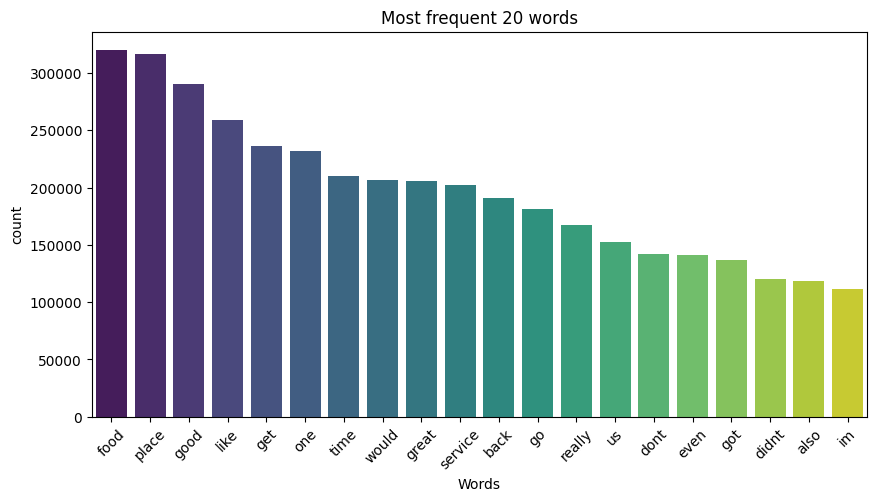

In [48]:
all_tokens = [token for tokens in train_df['tokens'] for token in tokens]
token_counter = Counter(all_tokens)
most_common = token_counter.most_common(20)
words, counts = zip(*most_common)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts),palette='viridis')
plt.title("Most frequent 20 words")
plt.xlabel("Words")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

In [18]:
vocab = {word: idx + 2 for idx, word in enumerate(token_counter.keys())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

print("\nVocabulary size (including <PAD> and <UNK>):", len(vocab))

def tokens_to_indices(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

train_df['token_indices'] = train_df['tokens'].apply(lambda tokens: tokens_to_indices(tokens, vocab))
test_df['token_indices'] = test_df['tokens'].apply(lambda tokens: tokens_to_indices(tokens, vocab))

example_indices = train_df.iloc[0]['token_indices']
print("\nSample token indices for first review:", example_indices)
example_tensor = torch.tensor(example_indices, dtype=torch.long)
print("Sample tensor:", example_tensor)

embedding_dim = 100
vocab_size = len(vocab)

embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

example_embedding = embedding_layer(example_tensor)
print("Example embedding shape:", example_embedding.shape)

max_seq_len = 128
pad_token = vocab['<PAD>']

def pad_sequence(seq, max_len=max_seq_len, pad_value=pad_token):
    if len(seq) > max_len:
        return seq[:max_len]
    else:
        return seq + [pad_value] * (max_len - len(seq))

def process_dataframe(df):
    df = df.copy()
    df['padded'] = df['token_indices'].apply(lambda s: pad_sequence(s, max_len=max_seq_len))
    df['rating_processed'] = df['rating'] - 1
    return df

train_df_processed = process_dataframe(train_df)
test_df_processed = process_dataframe(test_df)



Vocabulary size (including <PAD> and <UNK>): 740105

Sample token indices for first review: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 10, 11, 35, 28, 36, 37, 38, 39, 40, 41, 42, 43, 21, 44, 45, 46, 47, 48, 49, 4, 50, 24, 51]
Sample tensor: tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 16, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 10, 11,
        35, 28, 36, 37, 38, 39, 40, 41, 42, 43, 21, 44, 45, 46, 47, 48, 49,  4,
        50, 24, 51])
Example embedding shape: torch.Size([57, 100])


In [19]:
train_df_processed

,rating,review,tokens,word_count,token_indices,padded,rating_processed
0,1,"Unfortunately, the frustration of being Dr. Go...","[unfortunately, frustration, dr, goldbergs, pa...",57,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0
1,2,Been going to Dr. Goldberg for over 10 years. ...,"[going, dr, goldberg, 10, years, think, one, 1...",41,"[52, 4, 50, 53, 54, 55, 56, 57, 38, 58, 59, 60...","[52, 4, 50, 53, 54, 55, 56, 57, 38, 58, 59, 60...",1
2,1,I don't know what Dr. Goldberg was like before...,"[dont, know, dr, goldberg, like, moving, arizo...",102,"[35, 85, 4, 50, 86, 87, 88, 89, 90, 91, 92, 14...","[35, 85, 4, 50, 86, 87, 88, 89, 90, 91, 92, 14...",0
3,1,I'm writing this review to give you a heads up...,"[im, writing, review, give, heads, see, doctor...",103,"[151, 152, 146, 49, 153, 154, 14, 36, 16, 155,...","[151, 152, 146, 49, 153, 154, 14, 36, 16, 155,...",0
4,2,All the food is great here. But the best thing...,"[food, great, best, thing, wings, wings, simpl...",43,"[202, 61, 203, 204, 205, 205, 18, 206, 207, 20...","[202, 61, 203, 204, 205, 205, 18, 206, 207, 20...",1
...,...,...,...,...,...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...,"[ryan, good, everyone, yelp, claimed, courteou...",24,"[21211, 13, 868, 462, 4136, 4363, 2045, 2843, ...","[21211, 13, 868, 462, 4136, 4363, 2045, 2843, ...",1
559996,2,Professional \nFriendly\nOn time AND affordabl...,"[professional, nfriendlynon, time, affordablen...",10,"[5522, 740103, 30, 740104, 593, 121, 141, 6952...","[5522, 740103, 30, 740104, 593, 121, 141, 6952...",1
559997,1,Phone calls always go to voicemail and message...,"[phone, calls, always, go, voicemail, messages...",10,"[21, 5407, 1179, 368, 5724, 826, 2123, 3845, 7...","[21, 5407, 1179, 368, 5724, 826, 2123, 3845, 7...",0
559998,1,Looks like all of the good reviews have gone t...,"[looks, like, good, reviews, gone, head, place...",44,"[361, 86, 13, 1379, 723, 2232, 227, 1924, 2121...","[361, 86, 13, 1379, 723, 2232, 227, 1924, 2121...",0


## Step 2: Model Construction

1. Embeddings and positional encoding: Define an embedding layer to map tokens into numerical vectors. If using pre-trained embeddings, ensure they are compatible with your model's input dimension.

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) 
        pe[:, 1::2] = torch.cos(position * div_term)  
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

2. Implement the core Transformer architecture:
   - Encoder: Utilize `nn.TransformerEncoder` with multiple `nn.TransformerEncoderLayer` instances. Each layer typically comprises a multi-head self-attention mechanism, a feed-forward layer, and layer normalization.
   - Decoder: Employ `nn.TransformerDecoder` with multiple `nn.TransformerDecoderLayer` instances. These layers incorporate masked self-attention, multi-head attention over the encoder outputs, and a feed-forward layer with layer normalization.
     
3. Depending on your task (e.g., classification, sequence generation), define an appropriate output layer. For classification tasks, you might use a linear layer with a softmax activation function. Additionally, for classification and regression related tasks, the decoder can be removed completely. Auto-regressive sequence generation requires a decoder.

In [21]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim,
                 num_encoder_layers, output_dim, max_seq_len, pad_token=0, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim,
                                      padding_idx=pad_token)
        self.pos_encoder = PositionalEncoding(d_model=embedding_dim, max_len=max_seq_len)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                   nhead=num_heads,
                                                   dim_feedforward=hidden_dim,
                                                   dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.pad_token = pad_token
        
    def forward(self, src):
        
        embedded = self.embedding(src)              
        embedded = self.pos_encoder(embedded)        
        
        embedded = embedded.transpose(0, 1)         
        key_padding_mask = (src == self.pad_token)     
        encoder_output = self.transformer_encoder(embedded, src_key_padding_mask=key_padding_mask)
        encoder_output = encoder_output.transpose(0, 1) 
        pooled = encoder_output.mean(dim=1)            
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)                       
        return logits

4.	Print model summary using torchinfo.summary

In [49]:
summary(model, input_size=(batch_size, max_seq_len), dtypes=[torch.long])

Layer (type:depth-idx)                        Output Shape              Param #
TransformerClassifier                         [64, 2]                   --
├─Embedding: 1-1                              [64, 128, 100]            74,010,500
├─PositionalEncoding: 1-2                     [64, 128, 100]            --
├─TransformerEncoder: 1-3                     [128, 64, 100]            --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [128, 64, 100]            66,628
│    │    └─TransformerEncoderLayer: 3-2      [128, 64, 100]            66,628
├─Dropout: 1-4                                [64, 100]                 --
├─Linear: 1-5                                 [64, 2]                   202
Total params: 74,143,958
Trainable params: 74,143,958
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.74
Input size (MB): 0.07
Forward/backward pass size (MB): 62.65
Params size (MB): 296.25
Estimated Total Size (MB

5. Briefly describe the Transformer architecture you have defined.

This model is a simplified transformer built for classification. It starts by turning words into vectors, adds fixed “positional” information so the order is known, and then passes the result through several layers of attention and feed-forward networks, each layer with shortcuts and normalization to help training. Finally, it averages the sequence information, applies dropout for regularization, and uses a simple linear layer to decide if the given review is positive or negative.

## Step 3: Training the Transformer

1. Preparing for training:
   - Divide the preprocessed data into training, validation, and testing sets using a common split ratio (e.g., 70:15:15 or 80:10:10).
   - Choose an appropriate loss function (e.g., cross-entropy loss for classification) and an optimizer (e.g., Adam) to update model parameters during training.

2. Define a training loop. E.g. forward pass, calculate loss, backward pass, update parameters. Train the model.

In [22]:
X_train = list(train_df_processed['padded'])
y_train = list(train_df_processed['rating_processed'])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

X_test = list(test_df_processed['padded'])
y_test = list(test_df_processed['rating_processed'])

X_train_tensor = torch.tensor(X_train_split, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_split, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_split, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


embedding_dim = 100
num_heads = 4
hidden_dim = 128
num_encoder_layers = 2
output_dim = 2 
learning_rate = 1e-3
weight_decay = 1e-4 
dropout = 0.1

vocab_size = len(vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerClassifier(vocab_size=vocab_size,
                              embedding_dim=embedding_dim,
                              num_heads=num_heads,
                              hidden_dim=hidden_dim,
                              num_encoder_layers=num_encoder_layers,
                              output_dim=output_dim,
                              max_seq_len=max_seq_len,
                              pad_token=pad_token,
                              dropout=dropout)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Step 4: Evaluation and Optimization

1. Check your model's performance on the validation set. Monitor metrics like accuracy or loss to track progress. Explore at least 3 optimization techniques to improve the performance of your Transformer model. E.g. regularization (L1/L2), dropout, early stopping, learning rate tuning.

In [23]:
n_epochs = 5
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
lambda_l1 = 1e-5

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(n_epochs):
    start_time = time.time()
    print(f"\n[Epoch {epoch+1}/{n_epochs}] Starting training at {time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    model.train()
    epoch_train_losses = []
    correct_train = 0
    total_train = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        if lambda_l1 > 0:
            l1_loss = 0.0
            for param in model.parameters():
                l1_loss += torch.sum(torch.abs(param))
            loss += lambda_l1 * l1_loss
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
        
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_y.size(0)
    
    avg_train_loss = np.mean(epoch_train_losses)
    train_accuracy = correct_train / total_train
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)
    
    model.eval()
    epoch_val_losses = []
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            epoch_val_losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == batch_y).sum().item()
            total_val += batch_y.size(0)
    
    avg_val_loss = np.mean(epoch_val_losses)
    val_accuracy = correct_val / total_val
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)
    
    epoch_time = time.time() - start_time
    print(f"[Epoch {epoch+1}/{n_epochs}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"Time taken for Epoch {epoch+1}: {epoch_time:.2f} seconds")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    scheduler.step()

if 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

model.eval()
test_losses = []
correct_test = 0
total_test = 0

all_test_preds = []
all_test_labels = []
all_test_probs = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        test_losses.append(loss.item())
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        correct_test += (preds == batch_y).sum().item()
        total_test += batch_y.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(batch_y.cpu().numpy())
        all_test_probs.extend(probs[:, 1].cpu().numpy())



[Epoch 1/5] Starting training at 2025-04-10 23:04:26
[Epoch 1/5] Train Loss: 67.9133 | Train Acc: 0.8801 | Val Loss: 0.2193 | Val Acc: 0.9106
Time taken for Epoch 1: 365.97 seconds

[Epoch 2/5] Starting training at 2025-04-10 23:10:32
[Epoch 2/5] Train Loss: 0.3784 | Train Acc: 0.9116 | Val Loss: 0.2060 | Val Acc: 0.9162
Time taken for Epoch 2: 365.92 seconds

[Epoch 3/5] Starting training at 2025-04-10 23:16:38
[Epoch 3/5] Train Loss: 0.3533 | Train Acc: 0.9164 | Val Loss: 0.2002 | Val Acc: 0.9183
Time taken for Epoch 3: 365.57 seconds

[Epoch 4/5] Starting training at 2025-04-10 23:22:43
[Epoch 4/5] Train Loss: 0.3414 | Train Acc: 0.9190 | Val Loss: 0.2030 | Val Acc: 0.9187
Time taken for Epoch 4: 365.61 seconds

[Epoch 5/5] Starting training at 2025-04-10 23:28:49
[Epoch 5/5] Train Loss: 0.3339 | Train Acc: 0.9206 | Val Loss: 0.1951 | Val Acc: 0.9222
Time taken for Epoch 5: 365.61 seconds


2. Discuss how the optimization techniques helped to improve the performance of the model.

L2 Regularization: It keeps the weights small by penalizing large ones, helping the model avoid overfitting.

L1 Regularization: It encourages the model to zero out less important features, simplifying the overall representation.

Dropout: It randomly deactivates neurons during training, preventing the model from relying too much on any single feature.

Early Stopping: It stops training when validation performance stops improving, reducing the risk of overfitting. This also saves a lot of training time

Learning Rate Scheduling: It gradually adjusts the learning rate during training to ensure stable convergence and fine-tuning.

3. Save the weights of the model that provides the best results. Check the saving and loading of models (Pytorch).

In [25]:
torch.save(model.state_dict(), "a2_part3_ithamizh_kisorese.pt")

4. Discuss the results and provide the following graphs:

   a. Training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss. Provide your short analysis.

In [26]:
avg_test_loss = np.mean(test_losses)
test_accuracy = correct_test / total_test
print(f"\nTest Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

epochs_range = range(1, len(train_loss_history)+1)



Test Loss: 0.1878 | Test Accuracy: 0.9246


b. Plot the training and validation accuracy over time (epochs).

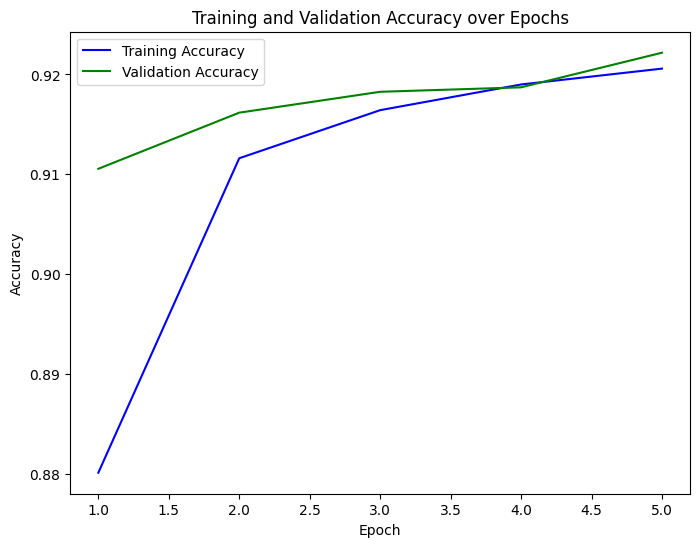

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc_history, label="Training Accuracy",color='blue')
plt.plot(epochs_range, val_acc_history, label="Validation Accuracy",color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

   c. Plot the training and validation loss over time (epochs).


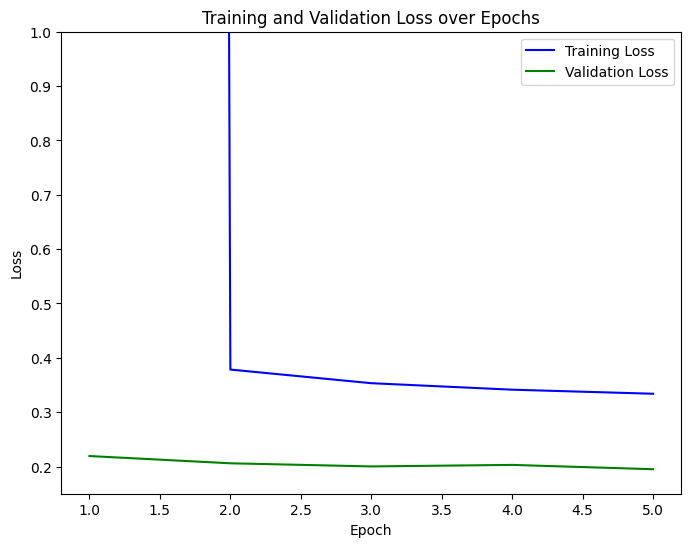

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss_history, label="Training Loss", color='blue')
plt.plot(epochs_range, val_loss_history, label="Validation Loss", color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.ylim(0.15, 1)  
plt.legend()
plt.show()


   d. Calculate and report other evaluation metrics such as Precision, recall and F1 score. You can use sklearn.metrics.precision_recall_fscore_support.


In [34]:
precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average='binary')
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")


Precision: 0.9232 | Recall: 0.9262 | F1 Score: 0.9247


   e. Plot the ROC curve.

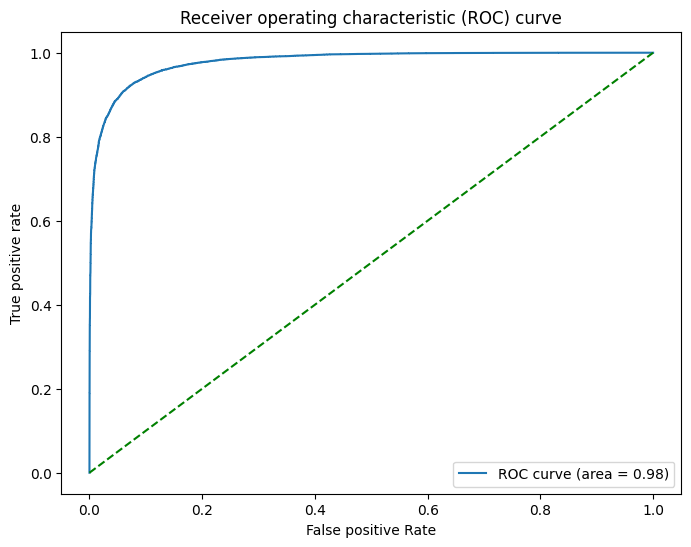

In [38]:
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.xlabel("False positive Rate")
plt.ylabel("True positive rate")
plt.title("Receiver operating characteristic (ROC) curve")
plt.legend()
plt.show()


#### Result Discussion:

The final accuracy of the model was around ~90 with a reducing trend in loss indicating that the model was training properly. We utilized the given test dataset too so the results are more in line with real life scenarios therefore we can be cofnident about this approach.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

### References:

- Dataset link - https://drive.google.com/file/d/0Bz8a_Dbh9QhbNUpYQ2N3SGlFaDg/view?usp=drive_link&resourcekey=0-99vcOBy-6AwpnHcS-zFIIQ
- https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
- https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html


6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Kisore, Indumathi  | Step 1 | 50,50  |
| Kisore, Indumathi  | Step 2 | 50,50  |
| Kisore, Indumathi | Step 3 | 50,50  |
| Kisore, Indumathi | Step 4 | 50,50  |
|   | **Total** | 100  |